In [1]:
import os
import h5py
import numpy as np

In [2]:
dat_dir = '/global/cscratch1/sd/chahah/gqp_mc/tng/'

In [3]:
_photo = h5py.File(os.path.join(dat_dir, 'Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_091.hdf5'), 'r')
# galaxies, [u, g, r, i, z, _, _, _], 12 projections
photo = _photo['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][...]

In [ ]:
Mg = photo[:,1,0]
Mr = photo[:,2,0]

In [4]:
mstar = []
for i in range(600): 
    _tng = h5py.File(os.path.join(dat_dir, 'fof_subhalo_tab_091.%i.hdf5' %i), 'r')
    try: 
        mstar.append(_tng['Subhalo']['SubhaloMassType'][...][:,4])
    except KeyError: 
        continue
logmstar = np.log10(np.concatenate(mstar)) + 10 

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


In [5]:
assert len(logmstar) == photo.shape[0]

Lets k-correct it to get $r$ band apparent agnitude: 
$$M_r -5 \log_{10} h = r - 5 \log_{10}(d_L(z)/10{\rm pc}) - 25 - ^{0.1}k(z)$$

* similar to k-correct given in McNaught-Roberts+(2014) 
$$^{0.1}k(z) = \sum\limits_{i=0}^4 A_i ( z - 0.1)^{4-i}$$

checkout Table 1 of Smith+(2017): 

In [7]:
def assign_Ai(g_r): 
    ''' given (M_g - M_r)0.1, return k-correct polynomial coefficients. 
    '''
    grs = np.array([0.131, 0.298, 0.443, 0.603, 0.785, 0.933, 1.067])
    A0s = np.array([-45.33, -20.08, -10.98, -3.428, 6.717, 16.76, 20.30])
    A1s = np.array([35.28, 20.14, 14.36, 9.478, 3.250, -2.514, -4.189])
    A2s = np.array([-6.604, -4.620, -3.676, -2.703, -1.176, 0.3513, 0.5619])
    A3s = np.array([-0.4805, -0.04824, 0.3395, 0.7646, 1.113, 1.307, 1.494])
    A4 = -0.103
    
    if len(g_r.shape) <1: 
        i = np.argmin(np.abs(g_r - grs))
        return np.array([A0s[i], A1s[i], A2s[i], A3s[i], A4])
    else: 
        i = np.argmin(np.abs(g_r[:,None] - np.array(grs)[None,:]), axis=1)
        return np.vstack([A0s[i], A1s[i], A2s[i], A3s[i], np.repeat(A4, len(g_r))]).T

In [8]:
not_nan = (np.isfinite(Mg) & np.isfinite(Mr))
print('%i of %i have finite Mg and Mr' % (np.sum(not_nan), len(not_nan)))

2000191 of 14746091 have finite Mg and Mr


In [9]:
As = assign_Ai(Mg[not_nan] - Mr[not_nan])

In [10]:
redshifts = np.random.uniform(0., 0.6, np.sum(not_nan))

In [11]:
k_0p1 = (As[:,0] * (redshifts - 0.1)**4 + 
         As[:,1] * (redshifts - 0.1)**3 + 
         As[:,2] * (redshifts - 0.1)**2 + 
         As[:,3] * (redshifts - 0.1)**1 + As[:,3])

In [12]:
import astropy.units as u
from astropy.cosmology import Planck15

In [13]:
dm = 5. * np.log10(Planck15.luminosity_distance(redshifts) / (10 * u.parsec))

In [14]:
r = Mr[not_nan] - 5 * np.log10(Planck15.h) + dm - k_0p1

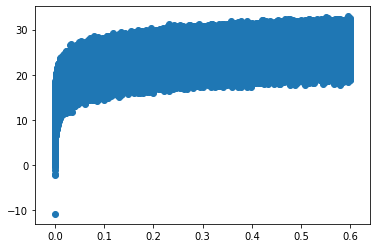

In [15]:
import matplotlib.pyplot as plt
plt.scatter(redshifts, r)

In [18]:
logMstar = logmstar[not_nan]

In [20]:
bgs_bright = (r < 19.5) 
bgs_faint = (r < 20.0)

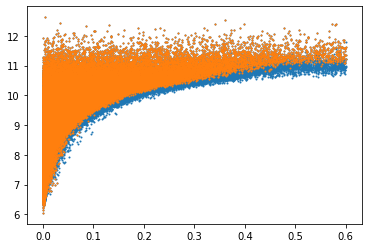

In [23]:
plt.scatter(redshifts[bgs_faint], logMstar[bgs_faint], s=1)
plt.scatter(redshifts[bgs_bright], logMstar[bgs_bright], s=1)

In [27]:
np.save(os.path.join(dat_dir, 'tng.logm_r_z.npy'), np.vstack([logMstar, r.value, redshifts]).T)